## 4. Modeling 

#### Pakete laden

Alle benötigten Pakete kommen aus der Scikit-Learn (kurz auch sklearn). Das ist eine Python Bibliothek mit der sich Machine Learning Anwendungen einfach umsetzen lassen. Zu den bekanntesten Voraussetzung für die Verwendung von sklearn zählen Numpy und SciPy.

**train_test_split**: Um die Effektivität eines Machine-Learning-Modells zu überprüfen, wird der ursprüngliche Datensatz in zwei Sets aufgeteilt: ein Trainingsset und ein Testset. Das Trainingsset wird verwendet, um das Modell auf einem Teil der Daten zu fitten, d. h. zu trainieren. Das Testset wird verwendet, um die Leistung des Modells auf dem anderen Teil der Daten zu bewerten. 

**accuracy_score**: Berechnet die Genauigkeit des Modells, also den Anteil der korrekt klassifizierten Beispiele.

**classification_report**: Erzeugt einen Bericht, der Präzision, Recall und F1-Score für jedes Label im Klassifikationsproblem berechnet.

**confusion_matrix**: Erzeugt eine Verwirrungsmatrix, die die Leistung eines Klassifikators darstellt, indem sie die Anzahl der wahren und falschen Klassifikationen zeigt.   
Eine Confusion Matrix visualisiert die Leistung eines Klassifikationsmodells, indem die tatsächlichen und vorhergesagten Klassifikationen verglichen werden:

|               | Vorhergesagt Positiv      | Vorhergesagt Negativ     |
|---------------|--------------|-------------|
| Tatsächlich Positiv       |   TP         |   FN        |
| Tatsächlich Negativ       |   FP         |   TN        |

- **True Positives (TP)**: Die Anzahl der tatsächlichen positiven Fälle, die korrekt als positiv vorhergesagt wurden.
- **False Positives (FP)**: Die Anzahl der tatsächlichen negativen Fälle, die fälschlicherweise als positiv vorhergesagt wurden.
- **True Negatives (TN)**: Die Anzahl der tatsächlichen negativen Fälle, die korrekt als negativ vorhergesagt wurden.
- **False Negatives (FN)**: Die Anzahl der tatsächlichen positiven Fälle, die fälschlicherweise als negativ vorhergesagt wurden.  

**DecisionTreeClassifier / RandomForestClassifier**: Sie dienen dazu, Entscheidungsbaum-Modelle für Klassifikationsaufgaben zu erstellen und zu trainieren

**GridSearchCV / RandomizedSearchCV**: Sie werden zur Hyperparameter-Optimierung verwendet. Es hilft dabei, die besten Hyperparameter für ein Modell zu finden, indem es systematisch verschiedene Kombinationen von Hyperparametern testet und bewertet.

**plot_tree**: Wird zur grafischen Wiedergabe eines Entscheidungsbaums benötigt

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, precision_recall_curve, roc_curve, precision_score, recall_score, f1_score,  mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import shap

import math

import xgboost as xgb
from xgboost import XGBClassifier
import sys

from scipy.stats import uniform, randint

#### Input: Bereinigte Daten von Data_Understanding_Preparation
Einlesen aus pickle file

In [ ]:
# Der Datensatz employee_data_transformed enthält den Datentyp "object", im Datensatz employee_data wurde der Datentyp "object" mittels One-Hot Encoding in Booleans umgewandelt

employee_data_transformed = pd.read_pickle('../HR_Data_raw.pkl')
employee_data = pd.read_pickle('../HR_Data_One_Hot_Encoded.pkl')

Überprüfen ob die Spalten und Daten wie erwartet bereinigt sind. 

In [ ]:
employee_data.tail()

#### Vorbereitung

Wir können einen Entscheidungsbaum relativ einfach dadurch trainieren, dass wir die Inputvariable X und die vorherzusagenden Klassen Y definieren und den Entscheidungsbaum aus Skicit-Learn darauf trainieren. 

1) Arrays, die aus dem zu teilenden Datensatz entnommen wurden.  
Beim überwachten Lernen sind diese Arrays das Input-Array X, das aus den erklärenden Variablen in den Spalten besteht, und das Output-Array y, das aus der Zielvariablen besteht. In diese Falle ist Attrition unsere Zielvariable, da dies vorhergesagt werden soll.

2) Split Trainings- und Testdaten

2.1) Die Größe des Testsets (test_size) und die Größe des Trainingssets (train_size).  
Die Größe jedes Satzes ist entweder eine Dezimalzahl zwischen 0 und 1, die einen Anteil des Datensatzes darstellt. Hier wählen wir als Trainingsgröße 30% unserers Datensatzes aus
Hinweis: Es ist ausreichend, nur eines dieser Argumente zu setzen, das zweite ist komplementär dazu.

2.2) Der random state (random_state).  
Der random state ist eine Zahl, die steuert, wie der Pseudo-Zufallsgenerator die Daten aufteilt.  
Hinweis: Wenn du eine ganze Zahl als random state wählst, werden die Daten bei jedem Aufruf der Funktion auf die gleiche Weise aufgeteilt. Dies macht den Code also reproduzierbar.   
[Warum "42"?](https://www.42-gmbh.de/unternehmen/warum-42/): Die Zahl 42 ist ein Insider-Witz in der Programmier- und Wissenschaftsgemeinschaft und stammt aus dem Buch "Per Anhalter durch die Galaxis" von Douglas Adams. In diesem Buch ist 42 die Antwort auf die ultimative Frage „nach dem Leben, dem Universum und allem“. Diese Antwort errechnet der größte existierende Computer in 7,5 Mio. Jahren:
![grafik.png](attachment:grafik.png)

In [ ]:
#Aufteilen der Daten in Zielvariable X und Attribute Y.
X = employee_data.drop('Attrition', axis=1)
y = employee_data.Attrition

#Aufteilen der Daten in Test und Trainingsdaten.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Anwendung von SMOTE auf die Trainingsdaten
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Überprüfen der neuen Klassenverteilung
print("Ursprüngliche Klassenverteilung:\n", y.value_counts())
print("Neue Klassenverteilung:\n", pd.Series(y_resampled).value_counts())

In [ ]:
# Funktion zum Evaluieren der verschiedenen Modelle
def evaluation(clf, X_resampled, y_resampled, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_resampled)
        clf_report = pd.DataFrame(classification_report(y_resampled, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_resampled, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_resampled, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

#### FeatureImportance testen auf originalen Datensatz

In [ ]:
employee_data_raw = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv', sep=',')
employee_data_raw.columns = employee_data_raw.columns.str.strip()

# Datenvorbereitung
categorical_col = []
for column in employee_data_raw.columns:
    if employee_data_raw[column].dtype == object:
        categorical_col.append(column)
for column in categorical_col:
    employee_data_raw[column] = employee_data_raw[column].astype("category").cat.codes
employee_data_raw['Attrition'] = employee_data_raw['Attrition'].astype("category").cat.codes

# Datenaufteilung
Xraw = employee_data_raw.drop('Attrition', axis=1).values  # Merkmale als NumPy-Array
yraw = employee_data_raw['Attrition'].values               # Zielvariable als NumPy-Array
Xraw_train, Xraw_test, yraw_train, yraw_test = train_test_split(Xraw, yraw, test_size=0.25, random_state=42)

# Anwendung von SMOTE auf die Trainingsdaten
smote = SMOTE(random_state=42)
X_raw_resampled, y_raw_resampled = smote.fit_resample(Xraw_train, yraw_train)

# Zählen der Anzahl der "Yes"-Labels (Attrition = 1) vor SMOTE
num_yes_before = np.sum(y_train == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) vor SMOTE: {num_yes_before}")
num_yes_after = np.sum(y_raw_resampled == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) nach SMOTE: {num_yes_after}")
#Entscheidungsbaum
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_raw_resampled, y_raw_resampled)

# Feature Wichtigkeit Roh-Daten ausgeben
feature_importances = tree_clf.feature_importances_
feature_names = employee_data_raw.drop('Attrition', axis=1).columns
feature_importance_employee_data_raw = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importance_employee_data_raw)

#### 1. Decision Trees und Random Forest

Erste Klassifizierung mit Trainings- und Testdaten für den Decision Tree.

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_resampled, y_resampled)

evaluation(tree_clf, X_resampled,  y_resampled, X_test,y_test, train=True)
evaluation(tree_clf, X_resampled,  y_resampled, X_test, y_test, train=False)

Die Feature Importance gibt an, nach welchen Variablen sich der Decision Tree für die Klassifizierung der Mitarbeitenden entscheidet. Mit viel Abstand wird dabei der MonthlyIncome als wichtigste Kennzahl bewertet. In etwas Abstand folgen dann EnvironmentSatisfaction, TotalWorkingYears, OverTime und DistanceFromHome.

In [ ]:
# Feature Wichtigkeit bereinigte Daten ausgeben
feature_importances = tree_clf.feature_importances_
feature_names = employee_data.drop('Attrition', axis=1).columns
feature_importance_employee_data = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importance_employee_data)

In [ ]:
#Entscheidungsbaum visualisieren
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, feature_names=feature_names, filled=True, fontsize=2)
plt.title("Vollständiger Entscheidungsbaum")
plt.show()

In [ ]:
# Ausschnitt des Entscheidungsbaums visualisieren (z.B. nur bis Tiefe 3)
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, feature_names=feature_names, filled=True, fontsize=10, max_depth=3)
plt.title("Ausschnitt des Entscheidungsbaums (Tiefe 3)")
plt.show()

**Parametertuning**

Tuning eines Einzelnen Entscheidungsbaums kann Ihnen helfen, ein Gefühl dafür zu bekommen, welche Parameterbereiche sinnvoll sind und wie der baum auf unterscheidliche Variablen reagiert. Dies kann indirekt Informationen für die Random Forest-Konfiguration liefern.

DecisionTree Parameter:

criterion{“gini”, “entropy”, “log_loss”}, default=”gini”   
Die Funktion zur Messung der Qualität einer Aufteilung. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain. Unterstützte Kriterien sind "gini" für die Gini-Verunreinigung und "entropy" für den Informationsgewinn. Beim Informationsgewinn wird das Entropiemaß als Maß für die Unreinheit verwendet und ein Knoten wird so aufgeteilt, dass er den größten Informationsgewinn bietet. Die Gini-Unreinheit hingegen misst die Divergenzen zwischen den Wahrscheinlichkeitsverteilungen der Werte des Zielattributs und teilt einen Knoten so auf, dass er die geringste Unreinheit ergibt.

splitter{“best”, “random”}, default=”best”   
Die Strategie, die für die Auswahl des Splits an jedem Knoten verwendet wird. Unterstützte Strategien sind "best" für die Auswahl des besten Splits und "random" für die Auswahl des besten zufälligen Splits.

max_depthint, default=None
Die maximale Tiefe des Baums. Falls keine, werden die Knoten so lange erweitert, bis alle Blätter rein sind oder bis alle Blätter weniger als min_samples_split Stichproben enthalten.

min_samples_splitint or float, default=2   
Die Mindestanzahl von Stichproben, die erforderlich ist, um einen internen Knoten zu teilen.
Wenn int, dann gilt min_samples_split als Mindestanzahl.
Wenn float, dann ist min_samples_split ein Bruch und ceil(min_samples_split * n_samples) ist die Mindestanzahl von Stichproben für jeden Split.

min_samples_leafint or float, default=1   
Die Mindestanzahl von Stichproben, die erforderlich ist, um einen Blattknoten zu erreichen. Ein Aufteilungspunkt in beliebiger Tiefe wird nur berücksichtigt, wenn er mindestens min_samples_leaf Trainingsstichproben in jedem der linken und rechten Zweige hinterlässt. Dies kann zu einer Glättung des Modells führen, insbesondere bei Regressionen.
Die Mindestanzahl von Stichproben, die für einen Blattknoten erforderlich sind. Ein Splitpunkt in beliebiger Tiefe wird nur berücksichtigt, wenn er mindestens min_samples_leaf Trainingsstichproben in jedem der linken und rechten Zweige hinterlässt. Dies kann zu einer Glättung des Modells führen, insbesondere bei Regressionen.
Wenn int, dann wird min_samples_leaf als Mindestanzahl betrachtet.
Wenn float, dann ist min_samples_leaf ein Bruch und ceil(min_samples_leaf * n_samples) ist die Mindestanzahl von Stichproben für jeden Knoten.

In [ ]:
# Manuelle Festlegung der Parameter
manual_params = {
    "criterion": "gini",        # "gini" oder "entropy" oder "log_loss"
    "splitter": "best",         # "best" oder oder "random"
    "max_depth": 10,            # Wertebereich ab 1
    "min_samples_split": 2,     # Wertebereich ab 2
    "min_samples_leaf": 2       # Wertebereich ab 1
}

# Entscheidung für das Modell mit den festgelegten Parametern
tree_clf = DecisionTreeClassifier(random_state=42, **manual_params)
tree_clf.fit(X_resampled, y_resampled)

evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=True)
evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=False)

**Grid Search Cross Validation**

Aschließend folgt die Parameteroptimierung über GridSearchCV, um die optimale Kombination zu erhatlen.

Die Kreuzvalidierung ist eine bekannte Technik im Bereich des Machine Learning und hilft zu verstehen, wie gut ein Modell auf ungesehene Daten reagiert. Sie kann genauso auch für das Hyperparameter Tuning verwendet werden, um verschiedene Parametereinstellungen zu testen und zu vergleichen. Die Cross Validation nutzt eine sogenannte Resampling-Technik bei der der Datensatz in mehrere Teilmengen unterteilt wird. Die verbreiteste Umsetzung ist dabei die k-fold Cross Validation, bei der insgesamt k Teilmengen gebildet werden. Dabei wird in jeder Iteration eine andere Menge als Validierungsdatensatz genutzt, um eine unabhängige Aussage über die Leistung des Modells treffen zu können. 

In vielen Fällen wird dafür der folgende Prozess genutzt: 

Partitionierung der Daten: Der Datensatz wird als erstes in die gleich großen Teilmengen gesplittet. Diese fungieren während dem Trainings entweder als Trainings- oder Validierungssatz. Die unterschiedlichen Validierungssätze können dann genutzt werden, um die Modellleistung unabhängig bewerten und vergleichen zu können.   

Auswahl von Hyperparametern: Vor dem Training wird ein Satz an Hyperparametern festgelegt, der in dieser Iteration getestet werden soll. Dies wurde durch die manuellen Anapssungen der Parameter erzielt.

Aggregieren der Ergebnisse: Anschließend können die Ergebnisse zusammengefasst werden, um ein optimales Set an Hyperparameter zu bestimmen.

Als optimal wird dabei nicht unbedingt die Auswahl betrachtet, die den höchsten Accuracy Score hat, sondern, die auch in den weiteren Kennzahlen performt. Dadurch wird zum Beispiel eine ungleichverteilung der Klassen vermieden, sodass die Vorhersage nicht meist auf "Mitarbeitende bleiben im Unternehmen" hinausläuft. Diese "Falschaussage" ist problematisch, da die Grundannahme der Personalabteilung lautet, dass die Mitarbeitenden bleiben und somit potenzielle Abgänge nicht erkannt werden, die durch eine korrekte Vorhersage verhindert hätten werden können.

In [ ]:
params = {
    "criterion":("gini", "entropy", "log_loss"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4, 5, 6, 7, 8, 9, 10], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(
    tree_clf, 
    params, 
    scoring="f1", 
    n_jobs=-1, 
    verbose=1, 
    cv=5
)

tree_cv.fit(X_resampled, y_resampled)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_resampled, y_resampled)
evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=True)
evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=False)

Erste Klassifizierung mit Trainings- und Testdaten für Random Forrest

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_resampled, y_resampled)

evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=True)
evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=False)

**Parametertuning**

Für Random Forests ist es üblich, GridSearchCV oder RandomizedSearchCV zu verwenden, um die optimale Kombinationen von Hyperparametern zu verwenden und das beste Modell auszuwählen.

Random Forest Parameter:

n_estimators: Die Anzahl der Bäume im Wald.

criterion: Die Funktion zur Messung der Qualität einer Aufteilung. Unterstützte Kriterien sind "gini" für die Gini-Unreinheit und "entropy" für den Informationsgewinn.

max_depth: Die maximale Tiefe des Baums. Falls keine, werden die Knoten so lange expandiert, bis alle Blätter rein sind oder bis alle Blätter weniger als min_samples_split samples enthalten.

min_samples_split: Die Mindestanzahl von Stichproben, die erforderlich ist, um einen internen Knoten zu teilen.

min_samples_leaf: Die Mindestanzahl von Stichproben, die erforderlich ist, um einen Blattknoten zu erreichen. Ein Aufteilungspunkt in beliebiger Tiefe wird nur berücksichtigt, wenn er mindestens min_samples_leaf Trainingsstichproben in jedem der linken und rechten Zweige hinterlässt. Dies kann zu einer Glättung des Modells führen, insbesondere bei Regressionen.

min_weight_fraction_leaf: Der minimale gewichtete Anteil der Gesamtsumme der Gewichte (aller Eingabestichproben), der an einem Blattknoten liegen muss. Wenn sample_weight nicht angegeben wird, haben die Stichproben das gleiche Gewicht.

max_features: Die Anzahl der Merkmale, die bei der Suche nach dem besten Split berücksichtigt werden solle

max_leaf_nodes: Wachsen lassen eines Baumes mit max_leaf_nodes in best-first fashion. Die besten Knoten werden als relative Verringerung der Unreinheit definiert. Wenn Keine, dann unbegrenzte Anzahl von Blattknoten.

min_impurity_decrease: Ein Knoten wird geteilt, wenn dieser Split eine Verringerung der Unreinheit von mindestens diesem Wert bewirkt.

min_impurity_split: Schwellenwert für das vorzeitige Anhalten des Baumwachstums. Ein Knoten wird geteilt, wenn seine Unreinheit über dem Schwellenwert liegt, andernfalls bleibt er ein Blatt.

bootstrap: Ob bei der Erstellung von Bäumen Bootstrap-Stichproben verwendet werden. Wenn False, wird der gesamte Datensatz zur Erstellung jedes Baums verwendet.

oob_score: Ob Out-of-Bag-Stichproben verwendet werden sollen, um die Generalisierungsgenauigkeit zu schätzen.

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf, 
    'bootstrap': bootstrap
}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(
    estimator=rf_clf, 
    scoring='f1',
    param_distributions=random_grid, 
    n_iter=200, 
    cv=5, 
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(X_resampled, y_resampled)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_resampled, y_resampled)

evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=True)
evaluation(tree_clf, X_resampled, y_resampled, X_test, y_test, train=False)

In [ ]:
# Berechnen der ROC-Kurve und AUC für den RandomForestClassifier
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

# Plotten der ROC-Kurve für RandomForestClassifier
plt.figure(figsize=(12, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()

#### 2. XGBoost

Ein weiterer, auf Entscheidungsbäume basierender Lernalgorithmus ist der sogenannte XGBoost (eXtreme Gradient Boosting). XGBoost unterstützt sowohl die Lösung von Klassifikations- als auch Regressionsaufgaben. Ähnlich dem Random Forest Algorithmus wird die Vorhersagegenauigkeit durch Kombination verschiedener Entscheidungsbäume erhöht, allerdings werden diese nicht unabhängig voneinander erstellt. Zur schrittweisen Verbesserung der Modelle auf Basis der Residuen nutzt XGBoost Gradient Boosting. So wird die Verlustfunktion während des Trainingsprozesses optimiert. Der Algorithmus bietet außerdem zahlreiche Hyperparameter zur Verbesserung der Modellleistung. Darunter auch Regularisierungstechniken wie L1- und L2 um Overfitting zu vermeiden und die Modellkompelxität zu kontrollieren. Nebst Anpassungsmöglichkeiten liegen die Stärken von XGBoost vor allem in der Parallelisierung und somit im effizienten Umgang mit großen Datensätze. Obwohl der Algorithmus Mechanismen zur Reduzierung von Overfitting bietet, kann die Vielschichtigkeit des Hyperparameter-Tunings dennoch zu Überanpassung führen. Außerdem ist die Interpretierbarkeit aufgrund der Komplexität eingeschränkt (Chen et al. 2014).

##### 2.1 Daten für das Training vorbereiten:

1. Zielvariable zunächst als "category" und dann in numerische Werte (binär in 0 und 1) umwandeln.

In [ ]:
# Erstellen und Trainieren des XGBoost Modells

# 1. Zielvariable in numerische Codes umwandeln (Yes --> 1, No --> 0)
if y_resampled.dtype == 'object':
    y_resampled = y_resampled.astype('category')
    y_resampled = y_resampled.cat.codes

if y_test.dtype == 'object':
    y_test = y_test.astype('category')
    y_test = y_test.cat.codes

if y.dtype == 'object':
    y = y.astype('category')
    y = y.cat.codes


##### 2.2 Hyperparameter definieren und Modell trainieren:

Zur Festlegung der Hyperparameter stehen unterschiedliche Ansätze zur Verfügung. Darunter **Grid Search** und **Random Search** (s. Gliederungspunkt 2.3)
Zunächst wird das Modell allerdings nur mit den folgenden 5 Parametern trainiert, die auf einen Standard-Wert festgelgt werden:

- *"objective"*: binäres Klassifikationsproblem mit einer logistischen Regression.
- *"max_depth"*: Maximale Tiefe jedes Entscheidungsbaum. Ein höherer Wert ermöglich komplexere Werte (Achtung: Overfitting).
- *"learning_rate"*: legt die Lernrate fest und steuert die Schrittweite des Gradientabstiegs.Ziel des Gradientenabstiegs ist das Finden der optimalen Werte der Modellparameter zur Minimierung der **Loss Function** (Misst Fehler zwischen vorhergesagten und tatsächlichen Werten, z.B. Mean Squared Error bei linearen Regression oder Log-Loss bei binären Klassifikation). Ein niedriger Werte macht Modell robust ggü. Overfitting (Achtung: mehr Iterationen nötig).
- *"n_estimators"*: Anzahl der Boosting-Runden. Jede Boosting-Runde (sequenzielles Training) fügt neuen Entscheidungsbaum hinzu und korrigiert die Fehler (Residuen) des vorherigen Baumes. Idee: Kombination vieler schwacher Modelle ergibt starkes Lernmodell.
- *"eval_metric"*: Metrik zur Evaluierung des Modells. "logloss" steht für logarithmischer Verlust (Logarithmic Loss) und bewertet wie gut das Klassifikationsmodell Wahrscheinlichkeiten für die Klassen vorhersagt. Beispiel einer "guten" Vorhersage: Tatsächliches Label ist 1 und Modell sagt Wahrscheinlichkeit von 0,9 vorher. Dann ist Log Loss relativ klein. Hier wird "logloss" als Evaluationsmetrik verwendet um Leistung des Modells während des Trainings zu bewerten (Ziel: Minimierung des logarithmischen Verlustes).


In [ ]:
# Erstellen und Trainieren des XGBoost-Modells mit XGBClassifier
xgb_model = XGBClassifier(objective='binary:logistic', max_depth=6, learning_rate=0.3, n_estimators=100, eval_metric='logloss')
# xgb_model = XGBClassifier()
xgb_model.fit(X_resampled, y_resampled)

# Vorhersagen mit dem Modell
xgb_preds = xgb_model.predict(X_test)
xgb_y_pred = (xgb_preds > 0.5).astype(int)


In [ ]:
conf_matrix = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(4.5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Quit'], yticklabels=['Stay', 'Quit'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
evaluation(xgb_model, X_resampled, y_resampled, X_test, y_test, train=True )
evaluation(xgb_model, X_resampled, y_resampled, X_test, y_test, train=False )

##### 2.3 Hyperparameter Tuning

Mit Hilfe von GridSearchCV kann aus einer Auswahl von Parametern die ideale Kombination ermittelt werden. 
Durch Verwendung von RandomSearchCV kann durch die Festlegung von Iterationen eine zufällig ideale Parameterkombination ermittelt werden.

- *max_depth:* Steuert, wie tief jeder einzelne Entscheidungsbaum wachsen kann. Größere Werte können zu komplexeren Modellen führen.
- *learning_rate (eta):* Kleinere Werte machen das Training langsamer, aber stabiler. Ein niedrigerer Wert erfordert oft mehr n_estimators.
- *n_estimators:* Gibt an, wie viele Bäume im Modell trainiert werden. Mehr Bäume können zu besseren Modellen führen, aber auch die Rechenzeit erhöhen.
- *subsample:* Der Anteil der Trainingsdaten, die für jede Boosting-Runde zufällig ausgewählt werden. Reduziert Overfitting, Werte zwischen 0.5 und 1.0 sind üblich.
- *colsample_bytree:* Der Anteil der Merkmale, die für das Training jedes Baumes zufällig ausgewählt werden. Reduziert Overfitting, indem es die Vielfalt der Bäume erhöht. Werte zwischen 0.5 und 1.0 sind üblich.
- *reg_alpha (alpha):* L1-Regularisierungsterm, der eine Strafe für die Summe der absoluten Werte der Koeffizienten hinzufügt. Fördert Sparsamkeit im Modell, indem es einige Koeffizienten auf genau Null setzt, was effektiv einer Feature-Auswahl entspricht und Overfitting reduziert.
- *reg_lambda (lambda):* L2-Regularisierungsterm, der eine Strafe für die Summe der Quadrate der Koeffizienten hinzufügt. Stabilisiert das Modell, indem es alle Koeffizienten schrumpft, um Überanpassung zu reduzieren, ohne sie auf Null zu setzen, was zu einem glatteren und weniger komplexen Modell führt.
- *gamma:* Mindesteste Verlustreduktion, die erforderlich ist, um eine Baumaufspaltung durchzuführen. Höhere Werte führen dazu, dass weniger Splits durchgeführt werden, was zu einfacheren und weniger overfitted Modellen führt.

Wie im Data Understanding bereits festgestellt wurde, ist die Zielvariable "Attrition" unausgeglichen ist. 1.233 (84%) Mitarbeitende haben das Unternehmen nicht verlassen, während nur 237 (16%) gegangen sind. XGBoost hat einen speziellen Parameter scale_pos_weight für unausgeglichene Klassen.
- *scale_pos_weight:* Kontrolliert das  Gleichgewicht zwischen positiven und negativen Werten. Der Wert wird verwendet, um den Gradienten für die positive Klasse zu skalieren. Dies hat zur Folge, dass das Modell beim Training der positiven Klasse Skalierungsfehler macht und das Modell dazu ermutigt, diese zu stark zu korrigieren. Dies kann wiederum dazu beitragen, dass das Modell eine bessere Leistung erzielt, wenn es Vorhersagen für die positive Klasse trifft. Wenn es zu weit geht, kann es dazu führen, dass das Modell die positive Klasse besser vorhersagt, was jedoch zu einer schlechteren Leistung der negativen Klasse oder beider Klassen führt. Ein typischer Wert wäre sum(negative instances) / sum(positive instances).



In [ ]:
# Random Search: Definiere Parametergrenzen
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.1, 0.5),
    'subsample': uniform(0, 0.8),
    'colsample_bytree': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
    'scale_pos_weight': randint(1,50)
}

# RandomizedSearchCV starten, n_iter gibt an, wieviele Iterationen durchgeführt werden
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=1,
    n_jobs=-1
)

# Fit
random_search.fit(X_resampled, y_resampled)

print(f"Best Parameter: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

In [ ]:
# Grid Search: Definiere Parameter, je mehr Parameter betrachtet werden sollen, desto länger dauert die Suche
# Daher werden hier nicht alle Variablen betrachtet 

param_grid = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [80, 100, 120],
    'subsample': [0.4, 0.6, 0.8],
    'colsample_bytree':[0.1, 0.2, 0.3],
    'scale_pos_weight' :[4, 6, 8]
    #'reg_alpha': [0, 0.01, 0.1, 1],
    #'reg_lambda': [0, 0.01, 0.1, 1],
    # 'gamma': [0, 0.1, 0.5, 1]

}

# Grid Search durchführen
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_resampled, y_resampled)


print(f"Best Parameter: {grid_search.best_params_}, BEst Score: {grid_search.best_score_}")

In [ ]:
# Erstellen und Trainieren des XGBoost-Modells mit angepassten Parametern
xgb_model = XGBClassifier(objective='binary:logistic',
                          max_depth=7, 
                          learning_rate=0.2, 
                          n_estimators=120,
                          subsample=0.6,
                          colsample_bytree=0.2,
                          scale_pos_weight=6, 
                          eval_metric='logloss')
# xgb_model = XGBClassifier()
xgb_model.fit(X_resampled, y_resampled)

# Vorhersagen mit dem Modell
xgb_preds = xgb_model.predict(X_test)
xgb_y_pred = (xgb_preds > 0.5).astype(int)

In [ ]:
conf_matrix = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(4.5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Quit'], yticklabels=['Stay', 'Quit'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Je höher der Parameter scale_pos_weight gesetzt wird, um so mehr verbessert sich die Vorhersage für die positive Klasse. Trotz eines relativ hohen scale_pos_weight, ist die Vorhersagegüte für die positive Klasse (Quit) weiterhin nicht gut. Im Testdatensatz wurde nur knapp die Hälfte der Personen, die das Unternehmen tatsächlich verlassen korrekt vorhergesagt. Bei etwas mehr als der Hälfte wurde hingegen vorhergesagt, dass sie das Unternehmen nicht verlassen.

In [ ]:
evaluation(xgb_model, X_resampled, y_resampled, X_test, y_test, train=True )
evaluation(xgb_model, X_resampled, y_resampled, X_test, y_test, train=False )

Durch die angepasste Parameterkonfigurationen hat sich der Accuracy Score zwar von 86,41 % auf 83,15 % verschlechtert. Allerdings wurde der Recall-Score (misst die Fähigkeit, alle positiven Fälle zu finden (Verhältnis positiver Vorhersagen zu tatsächlich positive Werten)) von 37,5 % auf 47,9 % verbessert.

##### 2.4 Visualisierung der Modellperformance

Die *ROC-Curve* (Receiver Operating Characteristic) ist ein Tool zur Bewertung der Leistung eines binären Klassifikationsmodells. Sie stellt die wahre positive Rate (True Positive Rate, TPR) gegenüber der falschen positiven Rate (False Positive Rate, FPR) dar, um die Trennschärfe des Modells bei verschiedenen Schwellenwerten zu visualisieren

In [ ]:
# Berechnen der FPR, TPR und AUC
fpr_xgb_model, tpr_xgb_model, _ = roc_curve(y_test, xgb_preds)
roc_auc_xgb_model = roc_auc_score(y_test, xgb_preds)

In [ ]:
# Plotten der ROC-Kurve für XGBoost
plt.figure(figsize=(12, 6))
plt.plot(fpr_xgb_model, tpr_xgb_model, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb_model:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")

##### 2.5 Kreuzvalidierung

Mit Kreuzvalidierung kann geprüft werden, wie gut ein Modell auf neue Daten angewendet werden kann. Dafür wird das Modell k-mal trainiert mit unterschiedlich großen Teilmengen. Die Modelleistung wird für jeden Durchlauf gemessen und ein Durchschnitt berechnet.

In [ ]:
# Kreuzvalidierung
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cross_val_results = cross_val_score(xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=7, 
                          learning_rate=0.2, 
                          n_estimators=120,
                          subsample=0.6,
                          colsample_bytree=0.2,
                          scale_pos_weight=6, 
                          eval_metric='logloss'), X, y, cv=kfold, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cross_val_results.mean()} +/- {cross_val_results.std()}")

##### 2.6 Vergleich Modell-Performance mit Daten im Originalformat vs. bereinigte Daten (One-Hot-Encoding)

Verbessert sich die ROC-Curve, wenn XGBoost auf den Originaldaten (Datentyp Object, der für XGBoost in kategoriale Variablen umgewandelt wird) anstatt auf den mittels One-Hot Encoding bereinigten Daten ausgeführt wird?

Hierfür wird der Datensatz employee_data_transformed benötigt. Dieser wird auf die gleiche Weise aufgeteilt in Trainings- und Testdaten wie der Datensatz employee_data (s.o.). Außerdem wird auch in diesem Datensatz mitttels SMOTE eine Gleichgewichtung der Zielvariablen erzeugt.

In [ ]:
# Datenvorbereitung
categorical_col = []
for column in employee_data_transformed.columns:
    if employee_data_transformed[column].dtype == object:
        categorical_col.append(column)
for column in categorical_col:
    employee_data_transformed[column] = employee_data_transformed[column].astype("category").cat.codes
employee_data_transformed['Attrition'] = employee_data_transformed['Attrition'].astype("category").cat.codes

#Aufteilen der Daten in Zielvariable X_2 und Attribute y_2.
X_2 = employee_data_transformed.drop('Attrition', axis=1).values  # Merkmale als NumPy-Array
y_2 = employee_data_transformed['Attrition'].values               # Zielvariable als NumPy-Array

#Aufteilen der Daten in Test und Trainingsdaten.
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.25, random_state=42)

smote = SMOTE(random_state=42)
X_2_resampled, y_2_resampled = smote.fit_resample(X_2_train, y_2_train)

# Zählen der Anzahl der "Yes"-Labels (Attrition = 1) vor SMOTE
num_yes_before = np.sum(y_2_train == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) vor SMOTE: {num_yes_before}")
num_yes_after = np.sum(y_2_resampled == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) nach SMOTE: {num_yes_after}")


In [ ]:
X_2 = employee_data_transformed.drop('Attrition', axis=1) # Zielvariable entfernen
y_2 = employee_data_transformed['Attrition']  # 'Attrition' Spalte als Series

# Train-Test-Split durchführen
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.25, random_state=42)

# Textfeatures in Kategorien umwandeln
categories = X_2_train.select_dtypes(include=object).columns.tolist()
for col in categories:
    X_2_train[col] = X_2_train[col].astype('category')
    X_2_test[col] = X_2_test[col].astype('category')

# Labels in numerische Codes umwandeln
if y_2_train.dtype == 'object':
    y_2_train = y_2_train.astype('category')
    y_2_train = y_2_train.cat.codes

if y_2_test.dtype == 'object':
    y_2_test = y_2_test.astype('category')
    y_2_test = y_2_test.cat.codes


smote = SMOTE(random_state=42)
X_2_resampled, y_2_resampled = smote.fit_resample(X_2_train, y_2_train)

# Zählen der Anzahl der "Yes"-Labels (Attrition = 1) vor SMOTE
num_yes_before = np.sum(y_2_train == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) vor SMOTE: {num_yes_before}")
num_yes_after = np.sum(y_2_resampled == 1)
print(f"Anzahl der 'Yes' (Attrition = 1) nach SMOTE: {num_yes_after}")

In [ ]:
# Erstellen der DMatrix
# DMatrix ist eine spezielle Datenstruktur, die von XGBoost verwendet wird.
# "enable_categorial=True" ermöglich die Verarbeitung kategorialer Daten

dtrain_reg = xgb.DMatrix(X_2_resampled, y_2_resampled, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_2_test, y_2_test, enable_categorical=True)

# Modell trainieren

params = {
    'objective': 'binary:logistic',
    'max_depth': 7,
    'eta': 0.2,
    'subsample': 0.6,
    'colsample_bytree':0.2,
    'scale_pos_weight':6,
    'eval_metric': 'logloss'
}
xgb_model_2 = xgb.train(params, dtrain_reg, num_boost_round=120)

In [ ]:
# Vorhersagen
y_pred_prob_2 = xgb_model_2.predict(dtest_reg)
y_pred_2 = (y_pred_prob_2 > 0.5).astype(int)


# Genauigkeit berechnen
accuracy = accuracy_score(y_2_test, y_pred_2)
mse = mean_squared_error(y_2_test, y_pred_prob_2)
rmse = np.sqrt(mse)
auc = roc_auc_score(y_2_test, y_pred_prob_2) 
fpr_xgb_model_2, tpr_xgb_model_2, _ = roc_curve(y_2_test, y_pred_prob_2)

print(f"Accuracy: {accuracy}")
print(f"mse: {mse}")
print(f"rmse: {rmse}")
print(f"Area under Curve: {auc}")

In [ ]:
# Plotten der ROC-Kurve für XGBoost
plt.figure(figsize=(12, 6))
plt.plot(fpr_xgb_model, tpr_xgb_model, color='darkorange', lw=2, label=f'ROC curve encoded (area = {roc_auc_xgb_model:0.4f})')
plt.plot(fpr_xgb_model_2, tpr_xgb_model_2, color='darkgreen', lw=2, label=f'ROC curve original (area = {auc:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")

##### 2.7 Visualisierung der Feature Importance und des Entscheidungsbaums

Der Feature Importance Plot berechnet, wie häufig das Feature verwendet wurde, um Entscheidungsbäume im Modell aufzuteilen. Nachfolgend wird die unterschiedliche Gewichtung der Features in Abhängigkeit der zugrunde liegenden Daten (Encoded oder original) dargestellt.

EmployeeNumber und Monthly Income sind in beiden Fällen sehr wichtig für die Aufteilung der Entscheidungsbäume. Beim Encoded Datensatz führt mit Abstand das MonthlyIncome, beim Original Datensatz mit Abstand die EmployeeNumber das Ranking an.

In [ ]:

xgb.plot_importance(xgb_model, importance_type="weight", max_num_features =10, title='Feature Importance - Encoded Data')
plt.show()

xgb.plot_importance(xgb_model_2, importance_type="weight", max_num_features =10, title='Feature Importance - Original Data')
plt.show()


Um die Entscheidungsregeln und die Struktur der Bäume besser zu verstehen, kann man sich diese grafisch darstellen lassen. Bei einer maximalen Tiefe von 7 wird der Baum allerdings schon sehr unübersichtlich.

In [ ]:
# plot des Entscheidungsbaumes
fig, ax = plt.subplots(figsize=(80,50)) 
xgb.plot_tree(xgb_model, num_trees=0, rankdir = 'LR',  ax=ax)
plt.show()

#### 3. SVM

Die Support Vector Machine (SVM) ist ein überwachter Lernalgorithmus, der versucht das Risiko von Overfitting zu verringern. Bei der SVM wird jedes Mitglied des Trainingsdatensatzes einer vor zwei Kategorien zugewiesen, sodass es sich um einen nicht-probabilistischen binären linearen Klassifikator handelt. Bei einer linearen Klassifikation werden die Eingabetrainingsdatenpunkte in einem Raum (Hyperplane) abgebildet, jeder mit einem anderen Klassenlabel, das durch eine klare Lücke voneinander getrennt ist. Neue Datenpunkte werden dann in denselben Raum abgebildet und als Teil einer Klasse vorhergesagt, je nachdem, auf welcher Seite der Lücke sie liegen. SVM kann aber auch nicht-lineare Klassifikationen durchführen. Nebst der Robustheit gegenüber Überanpassung liegt der Vorteil in der Effektivität in hochdimensionalen Räumen (also wenn die Anzahl der Merkmale größer als die Anzahl an Beobachtungen ist). Durch verschiedene Kernel-Funktionen (darunter linear, polynominal und sigmoid) sind SVMs flexibel auf verschiedene Datensätze und Problemtypen einsetzbar. Allerdings gestaltet sich die Modellauswahl mitunter durch das Hyperparameter-Tuning und die Kernel-Auswahl als komplex. Unter der Modellkomplexität leidet ebenfalls die Interpretierbarkeit (Cortes und Vapnik 1995).

In [ ]:
# Erstellen und trainieren des SVM Modells 
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm.fit(X_resampled, y_resampled)
evaluation(svm, X_resampled,  y_resampled, X_test, y_test, train=True)
evaluation(svm, X_resampled,  y_resampled, X_test, y_test, train=False)

Verwendeter Kern: rbf - Auch als Gaussian Kernel bezeichnet, misst er die Ähnlichkeit der Datenpunkte, indem er den euklidischen Abstand in den exponentiellen Term einbezieht. Das dieser Kern besonders effektiv bei komplexen und nichtlinearen Mustern ist, ist er im Falle dieses Datensatzes geeignet. 

PCA wird angewendet, um die Dimensionen des hochdimensionalen HR-Datensatzes zu reduzieren, der 40 Merkmale umfasst. Diese Technik transformiert die Daten in einen kleineren Raum (z. B. 2D), indem sie die Hauptkomponenten wählt, die die meiste Varianz erklären. Dies erleichtert die Visualisierung und Interpretation des Modells, insbesondere bei der Darstellung von Entscheidungsgrenzen des SVM-Modells in zwei Dimensionen. Außerdem hilft PCA, irrelevante oder korrelierte Merkmale zu entfernen, was die Effizienz und Performance des Modells verbessern kann.

In [ ]:
pca = PCA()
pca.fit(X_resampled)  # X ist der ursprüngliche Datensatz ohne Zielvariable
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Anzahl der Hauptkomponenten')
plt.ylabel('Kumulierte erklärte Varianz')
plt.title('Varianz erklärt durch PCA')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Varianz')
plt.legend(loc='best')
plt.show()

In [46]:
# PCA-Komponenten und ihre Bedeutung für die ursprünglichen Features
components = pca.components_
features = X_resampled.columns  # Namen der Features

# Ausgabe der ersten zwei Hauptkomponenten
for i in range(2):  # oder die Anzahl der gewünschten Komponenten
    component = components[i]
    feature_importance = sorted(zip(features, component), key=lambda x: abs(x[1]), reverse=True)
    print(f"Hauptkomponente {i + 1}:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance:.4f}")

Hauptkomponente 1:
MonthlyIncome: 1.0000
EmployeeNumber: -0.0027
TotalWorkingYears: 0.0014
Age: 0.0011
YearsAtCompany: 0.0008
YearsInCurrentRole: 0.0004
YearsWithCurrManager: 0.0003
YearsSinceLastPromotion: 0.0003
JobLevel: 0.0002
NumCompaniesWorked: 0.0001
DistanceFromHome: -0.0001
Education: 0.0000
JobRole_Manager: 0.0000
JobRole_Research Scientist: -0.0000
JobRole_Laboratory Technician: -0.0000
JobRole_Research Director: 0.0000
RelationshipSatisfaction: 0.0000
WorkLifeBalance: 0.0000
MaritalStatus_Married: 0.0000
BusinessTravel_Travel_Rarely: 0.0000
Department_Sales: 0.0000
JobRole_Sales Executive: 0.0000
Gender: 0.0000
JobRole_Sales Representative: -0.0000
MaritalStatus_Single: -0.0000
EducationField_Medical: 0.0000
Department_Research & Development: -0.0000
JobInvolvement: 0.0000
JobRole_Manufacturing Director: 0.0000
EducationField_Marketing: 0.0000
MaritalStatus_Divorced: 0.0000
JobSatisfaction: 0.0000
EnvironmentSatisfaction: 0.0000
JobRole_Healthcare Representative: 0.0000
Ove

In [ ]:
# Dimensionsreduktion mit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Trainieren des SVM-Modells auf den reduzierten Daten
svm_pca = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_pca.fit(X_pca, y_resampled)

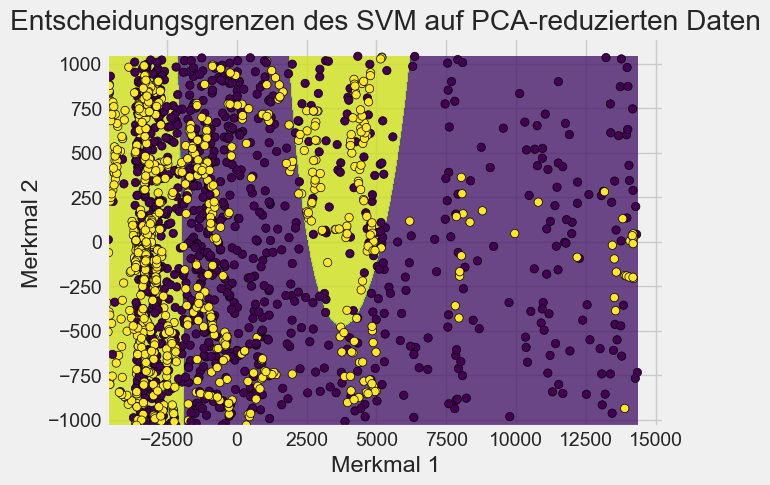

In [40]:
# Visualisierung der Entscheidungsgrenzen
def plot_decision_boundary(X, y, model, title='Entscheidungsgrenze'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 8),
                         np.arange(y_min, y_max, 8))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.viridis)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.viridis)
    plt.title(title)
    plt.xlabel('Merkmal 1')
    plt.ylabel('Merkmal 2')
    plt.show()

# Plot der Entscheidungsgrenzen
plot_decision_boundary(X_pca, y_resampled, svm_pca, title='Entscheidungsgrenzen des SVM auf PCA-reduzierten Daten')

In [42]:
evaluation(svm_pca, X_pca,  y_resampled, X_test, y_test, train=True)

Train Result:
Accuracy Score: 65.33%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.666667    0.641988  0.653341     0.654327      0.654327
recall       0.613363    0.693319  0.653341     0.653341      0.653341
f1-score     0.638905    0.666667  0.653341     0.652786      0.652786
support    913.000000  913.000000  0.653341  1826.000000   1826.000000
_______________________________________________
Confusion Matrix: 
 [[560 353]
 [280 633]]



Das PCA-Reduzierte Datenset verbessert die Ergebnisse des Modells nicht.  
Mithilfe von GridSearch wird nun eine geeignete Parameterkombination identifiziert. 

In [ ]:
svm = SVC(random_state=42)

param_grid = [
    {'C': [0.1, 1, 6, 10], 'gamma': [0.001, 0.005, 0.01], 'kernel': ['rbf']},
]


search = GridSearchCV(svm, param_grid=param_grid, scoring='roc_auc', cv=3, refit=True, verbose=1)
search.fit(X_resampled, y_resampled)

Bei mehrmaligem Testen mit unterschiedlichen RandomStates wird deutlich, dass die geeigneten Parameterkombinationen stark voneinander abweichen. 

In [ ]:
svm = SVC(**search.best_params_, probability=True)
svm.fit(X_resampled, y_resampled)

evaluation(svm, X_resampled,  y_resampled, X_test, y_test, train=True)
evaluation(svm, X_resampled,  y_resampled, X_test, y_test, train=False)

##### Visualisierung der Modellperformance

Die *ROC-Curve* (Receiver Operating Characteristic) ist ein Tool zur Bewertung der Leistung eines binären Klassifikationsmodells. Sie stellt die wahre positive Rate (True Positive Rate, TPR) gegenüber der falschen positiven Rate (False Positive Rate, FPR) dar, um die Trennschärfe des Modells bei verschiedenen Schwellenwerten zu visualisieren

In [ ]:
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm.predict(X_test))
roc_auc_svm = roc_auc_score(y_test, svm.predict(X_test))

In [ ]:
# Plotten der ROC-Kurve für SVM
plt.figure(figsize=(12, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.legend(loc="lower right")

### Vergleich der Methoden 
Im Folgenden werden die zuvor angewendeten Modelle SVM, XGBoost und Random Forest verglichen um zu bewerten, welches Modell die besten Ergebnisse liefert. 

In [ ]:
# Plotten der ROC-Kurven der verschiedenen Modelle
plt.figure(figsize=(12, 6))

# ROC-Kurve vor dem Tuning
plt.subplot(1, 3, 1)
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.legend(loc="lower right")

# ROC-Kurve XGBoost
plt.subplot(1, 3, 2)
plt.plot(fpr_xgb_model_2, tpr_xgb_model_2, color='darkorange', lw=2, label=f'ROC curve original (area = {auc:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC XGBoost')
plt.legend(loc="lower right")

# ROC-Kurve Random Forest
plt.subplot(1, 3, 3)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Random Forest')
plt.legend(loc="lower right")

plt.tight_layout()

### Erklärung der Vorhersagen mittels SHAP

SHapley Additive exPlanations (SHAP) ist eine Methode zur Erklärung der Vorhersagen von Machine-Learning-Modellen. In XGBoost wird SHAP verwendet, um die Beitrage einzelner Merkmale zu den Modellvorhersagen zu quantifizieren und zu visualisieren. 

SHAP-Werte quantifizieren den Einfluss jedes Merkmals auf die Modellvorhersage.
Mit SHAP können verschiedene Plots erstellt werden, um die Bedeutung und den Einfluss der Merkmale zu visualisieren.

- Im *Summary Plot* sind die Merkmale nach Bedeutung sortiert. Die X-Achse zeigt den Einfluss des Merkmals auf die Vorhersage. 
Postive Werte bedeuten, dass das Merkmal die Wahrscheinlichkeit erhöht, dass das Modell eine positive Klasse vorhersagt. Negative Werte bedeuten, dass das Merkmal diese Wahrscheinlichkeit verringert. 
Die Farbe repräsentiert den Wert des Merkmales (rot hohe Werte, blau niedrige Werte)

- Ein *Dependence Plot* zeigt die Beziehung zwischen den SHAP-Werten eines bestimmten Merkmals und den Werten dieses Merkmals selbst.

In [ ]:
# Erstellung SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

# Dependence plot für das Merkmal "Monthly Income"
shap.dependence_plot('MonthlyIncome', shap_values, X_test)